In [44]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,  StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
columns = ["id", "label", "statement", "subject", "speaker", "speaker_job", "state", "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]

In [3]:
test = pd.read_csv('liar_dataset/test.tsv', sep='\t', header=0, names=columns)
train = pd.read_csv('liar_dataset/train.tsv', sep='\t',header=0, names=columns)
valid = pd.read_csv('liar_dataset/valid.tsv', sep='\t',header=0, names=columns)

In [4]:
train.head()

,id,label,statement,subject,speaker,speaker_job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [5]:
train.loc[0][2]

/var/folders/wq/npwh9kl149n1hscrwfjbphbw0000gn/T/ipykernel_51412/982008797.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train.loc[0][2]


'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'

In [6]:
len(test)

1266

In [7]:
len(train)

10239

In [8]:
len(valid)

1283

In [9]:
train = pd.concat([train, valid])

In [10]:
train.head()

,id,label,statement,subject,speaker,speaker_job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [11]:
len(train)

11522

In [12]:
train = train[['statement','label']]
test = test[['statement', 'label']]

In [13]:
train.head()

,statement,label
0,When did the decline of coal start? It started...,half-true
1,"Hillary Clinton agrees with John McCain ""by vo...",mostly-true
2,Health care reform legislation is likely to ma...,false
3,The economic turnaround started at the end of ...,half-true
4,The Chicago Bears have had more starting quart...,true


In [14]:
label_mapping = {"true": 1, "mostly-true": 1, "half-true": 1, "barely-true": 0, "false": 0, "pants-fire": 0}

In [15]:
train.loc[:,'label'] = train['label'].map(label_mapping)
test.loc[:,'label'] = test['label'].map(label_mapping)

In [16]:
train.head()

,statement,label
0,When did the decline of coal start? It started...,1
1,"Hillary Clinton agrees with John McCain ""by vo...",1
2,Health care reform legislation is likely to ma...,0
3,The economic turnaround started at the end of ...,1
4,The Chicago Bears have had more starting quart...,1


In [17]:
train.isna().sum()
test.isna().sum()

statement    0
label        0
dtype: int64

In [18]:
print(train['label'].value_counts())
print(test['label'].value_counts())

label
1    6420
0    5102
Name: count, dtype: int64
label
1    713
0    553
Name: count, dtype: int64


In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.strip()
    return text

In [20]:
train.loc[:,'statement'] = train['statement'].apply(clean_text)
test.loc[:,'statement'] = test['statement'].apply(clean_text)

In [21]:
train.head()

,statement,label
0,when did the decline of coal start it started ...,1
1,hillary clinton agrees with john mccain by vot...,1
2,health care reform legislation is likely to ma...,0
3,the economic turnaround started at the end of ...,1
4,the chicago bears have had more starting quart...,1


In [22]:
(1283 + 1266)/10239

0.2489500927824983

In [23]:
train['label'] = train['label'].astype(int)
test['label'] = test['label'].astype(int)

In [24]:
X_train = train['statement']
y_train = train['label']
X_test = test['statement']
y_test = test['label']

print(train['label'].dtype)
print(train['label'].unique())

int64
[1 0]


In [25]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [26]:
pipeline = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english', max_features=5000)),
    ('classifier', MultinomialNB())
])

In [28]:
cv_scores = cross_val_score(pipeline,X_train,y_train,cv=cv,scoring='accuracy')

In [29]:
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation: {cv_scores.std():.2f}")

Cross-validation scores: [0.6        0.60780911 0.609375   0.59244792 0.58984375]
Mean Accuracy: 0.60
Standard Deviation: 0.01


In [31]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('classifier', MultinomialNB())])

In [32]:
y_pred = pipeline.predict(X_test)

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.61

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.47       553
           1       0.62      0.78      0.69       713

    accuracy                           0.61      1266
   macro avg       0.60      0.58      0.58      1266
weighted avg       0.60      0.61      0.59      1266



NameError: name 'plt' is not defined

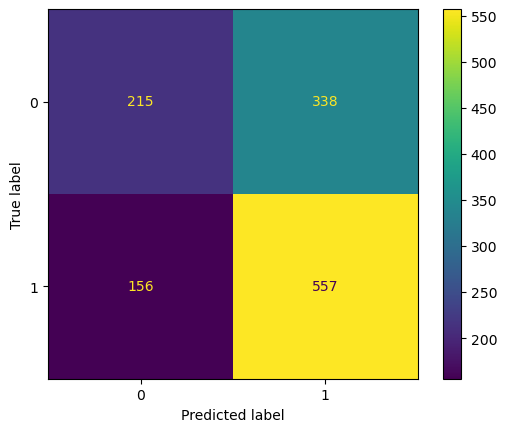

In [36]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

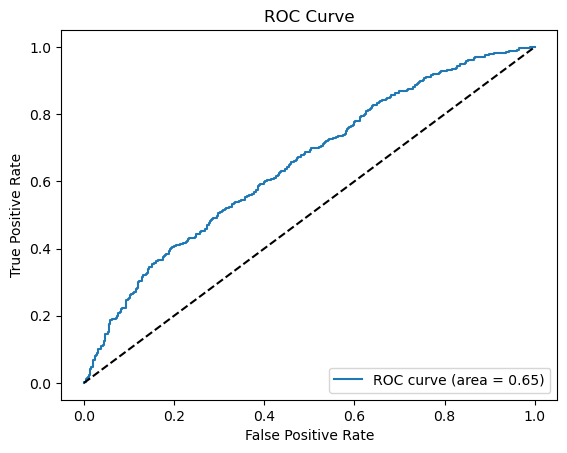

In [43]:
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability of positive class

# 6. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()